In [1]:
import os

import numpy as np
import pandas as pd

import IPython.display as ipd

import torchaudio
import datasets as hfd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1)

In [2]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [3]:
DATA_ROOT_DP = os.environ['DATA_HOME']
CV_DP = f'{DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19/be'
CLIPS_DP = os.path.join(CV_DP, 'clips')

In [4]:
df_dev = pd.read_csv(os.path.join(CV_DP, 'dev.tsv'), delimiter='\t')
logger.debug(f'df_dev.shape: {df_dev.shape}')

2022-03-28 20:18:36,964:STT:DEBUG:df_dev.shape: (15803, 10)


In [5]:
df_dev.head(2)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,41fd86ef04ed09d30e0b82d494afa3b7c37542bcae42dd...,common_voice_be_26930039.mp3,"Будынак ратушы быў драўляны, прамавугольны ў п...",3,0,teens,female,NaN,be,NaN
1,41fd86ef04ed09d30e0b82d494afa3b7c37542bcae42dd...,common_voice_be_26930040.mp3,"Перамяшчэнне жывёл, выклікана неабходнасцю змя...",2,1,teens,female,NaN,be,NaN


## transform dataset

In [129]:
ds = hfd.Dataset.from_pandas(df_dev[['path', 'sentence']].head(1000))

In [130]:
ds

Dataset({
    features: ['path', 'sentence'],
    num_rows: 1000
})

In [131]:
ds.cache_files

[]

In [132]:
def get_full_path(example, root_dp: str):
    example['path'] = os.path.join(root_dp, example['path'])
    return example

In [133]:
ds = ds.map(get_full_path, fn_kwargs=dict(root_dp=CLIPS_DP))

ds = ds.cast_column('path', hfd.Audio(sampling_rate=16_000, mono=True))
ds = ds.rename_column('path', 'audio')

0ex [00:00, ?ex/s]

In [134]:
ds

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 1000
})

## datasets.Audio vs torchaudio.load

In [118]:
ix = 853
print(os.path.relpath(ds[ix]['audio']['path'], CV_DP))

x1 = ds[ix]['audio']

x2 = torchaudio.load(ds[ix]['audio']['path'])

x2r = list(x2)
x2r[0] = resampler(x2[0])
x2r[1] = 16_000

print(x2[0].max().item() == x2r[0].max().item())
print(x1['array'].max() == x2r[0].max().item())
print(x1['array'].max(), x2[0].max().item(), x2r[0].max().item())

clips/common_voice_be_29071231.mp3
False
True
0.42713568 0.43676280975341797 0.4271356761455536


In [119]:
ipd.Audio(data=x1['array'], rate=x1['sampling_rate'], autoplay=True)

In [120]:
ipd.Audio(data=x2r[0], rate=x2r[1], autoplay=True)

In [121]:
ipd.Audio(data=x2[0], rate=x2[1], autoplay=True)

## buid statistics

In [19]:
def load_mp3(example, normalize: bool, root_dp=None, add_stats: bool = False):
    # torchaudio.load returns an audio as 2d tensor [channels, time]
    # and samples are normalized to fit in the range of [-1.0, 1.0].
    # TODO: check whether we can normalize inputs.
    audio, sampling_rate = torchaudio.load(
        fp, 
        normalize=normalize,
        channels_first=True,
    )
    
    example['n_channels'] = audio.shape[0]
    example['sampling_rate'] = sampling_rate
    
    # read audio only from 1st channel.
    # here audio is a torch.tensor. it will be converted to list 
    # by underlying logic in datasets.Dataset.
    audio = audio[0]
    example['audio'] = audio
    
    if add_stats is True:
        example['abs_max'] = audio.abs().max().item()
        example['mean'] = audio.mean().item()
        
    return example

In [20]:
x = load_mp3(ds[0], normalize=True, add_stats=True)

In [21]:
x

{'path': 'common_voice_be_26930039.mp3',
 'sentence': 'Будынак ратушы быў драўляны, прамавугольны ў плане, трохпавярховы, пакрыты высокім двухсхільным дахам.',
 'n_channels': 1,
 'sampling_rate': 32000,
 'audio': tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0937e-04, 1.1069e-04,
         6.3181e-06]),
 'abs_max': 0.13264918327331543,
 'mean': -5.134404091222677e-06}

In [22]:
ds = ds.map(
    load_mp3, num_proc=2,
    fn_kwargs=dict(normalize=True, add_stats=True)
)
ds

Dataset({
    features: ['path', 'sentence', 'n_channels', 'sampling_rate', 'audio', 'abs_max', 'mean'],
    num_rows: 1000
})

In [ ]:
ds_stats.head()

In [32]:
ds_stats['n_channels'].value_counts()

1    100
Name: n_channels, dtype: int64

In [33]:
ds_stats['sampling_rate'].value_counts()

32000    100
Name: sampling_rate, dtype: int64

count    100.000000
mean       0.525938
std        0.283484
min        0.066378
25%        0.221076
50%        0.575483
75%        0.782295
max        1.000000
Name: abs_max, dtype: float64

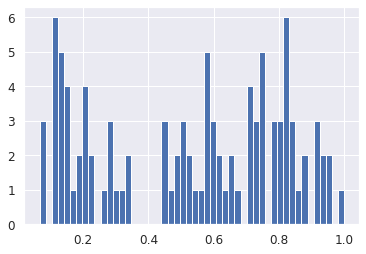

In [34]:
x = ds_stats['abs_max']
display(x.describe())
x.hist(bins=50);

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: abs_min, dtype: float64

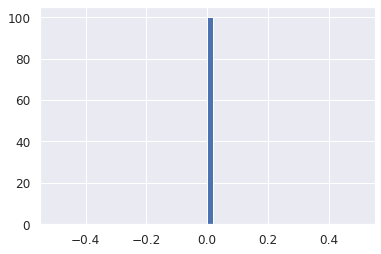

In [35]:
x = ds_stats['abs_min']
display(x.describe())
x.hist(bins=50);

count    1.000000e+02
mean    -9.194552e-06
std      4.581698e-05
min     -2.591412e-04
25%     -7.041530e-06
50%     -6.433467e-07
75%      4.735213e-06
max      6.875351e-05
Name: mean, dtype: float64

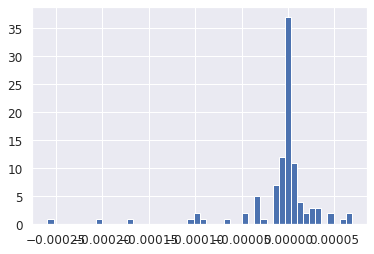

In [36]:
x = ds_stats['mean']
display(x.describe())
x.hist(bins=50);

count    100.000000
mean       0.063539
std        0.043785
min        0.008346
25%        0.022222
50%        0.055298
75%        0.092799
max        0.177502
Name: std, dtype: float64

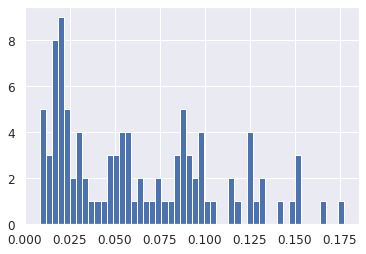

In [37]:
x = ds_stats['std']
display(x.describe())
x.hist(bins=50);

In [36]:
ix = 3
print(ds[ix]['sentence'])
ipd.Audio(data=ds[ix]['audio'], rate=ds[ix]['sampling_rate'], autoplay=True)

Да алтарнай часткі далучаюцца бакавыя вузкія рызніцы.
